# Customer churn - Telecom

## import and settings

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

**Plotty setting**

In [2]:
# Set Plotly as Pandas plotting backend

pd.options.plotting.backend = "plotly"
np.set_printoptions(precision=2, suppress=True)
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format

## Data collection

In [9]:

# Download latest version
path = kagglehub.dataset_download("mnassrib/telecom-churn-datasets")

print("Path to dataset files:", path)

path = "/root/.cache/kagglehub/datasets/mnassrib/telecom-churn-datasets/versions/1"

# רשימת קבצים בתיקייה
files = os.listdir(path)
print(files)
# === 2. קריאת הדאטה ===
train_path = "/root/.cache/kagglehub/datasets/mnassrib/telecom-churn-datasets/versions/1/churn-bigml-80.csv"
test_path  = "/root/.cache/kagglehub/datasets/mnassrib/telecom-churn-datasets/versions/1/churn-bigml-20.csv"
df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

Path to dataset files: /kaggle/input/telecom-churn-datasets
['churn-bigml-20.csv', 'churn-bigml-80.csv']


In [10]:

# הצגת מידע ראשוני
print(df_train.head())
print(df_train.info())
print(df_train.describe(include="all"))

  State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25             265.10              110   
1                     26             161.60              123   
2                      0             243.40              114   
3                      0             299.40               71   
4                      0             166.70              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07             197.40               99             16.78   
1             27.47   

### **Missing values**

In [11]:
# בדיקה של חוסרים
print("Missing values per column:")
print(df_train.isnull().sum())
print(df_test.isnull().sum())

Missing values per column:
State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64
State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total ni

### **Target values counter**


חלוקת target - Churn:
Churn
False    2278
True      388
Name: count, dtype: int64


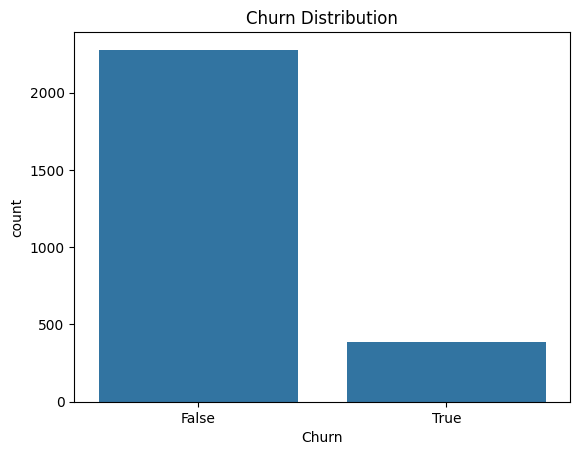


חלוקת target - Churn:
Churn
False    572
True      95
Name: count, dtype: int64


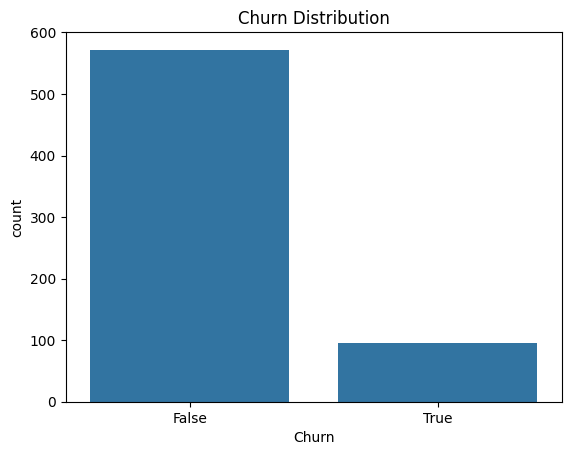

In [12]:
#  בדיקת חלוקת target 'Churn' ===
print("\nחלוקת target - Churn:")
print(df_train['Churn'].value_counts())
# גרף חלוקת churn
sns.countplot(x='Churn', data=df_train)
plt.title("Churn Distribution")
plt.show()

#  בדיקת חלוקת target 'Churn' ===
print("\nחלוקת target - Churn:")
print(df_test['Churn'].value_counts())
# גרף חלוקת churn
sns.countplot(x='Churn', data=df_test)
plt.title("Churn Distribution")
plt.show()

###**Print distributions**

**Training Data frame**

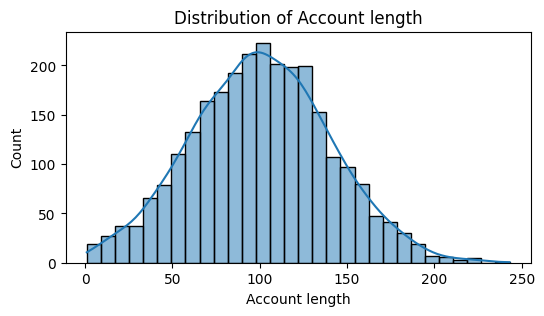

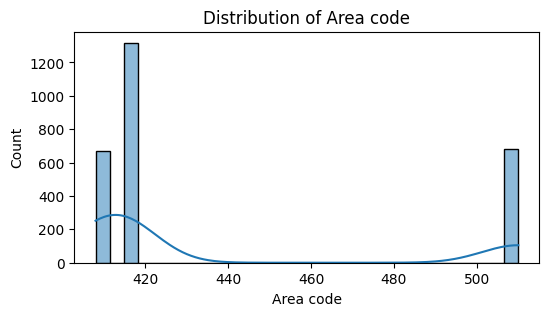

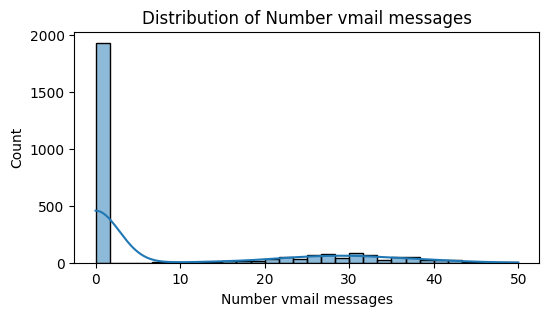

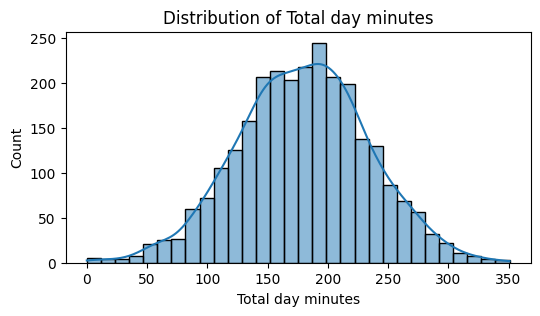

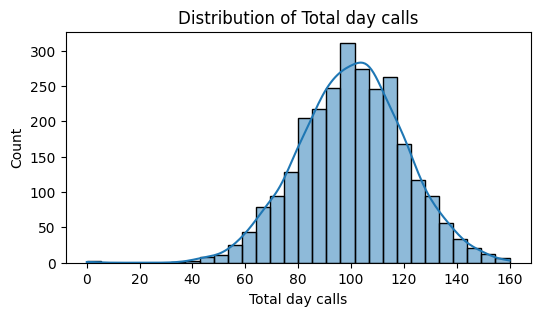

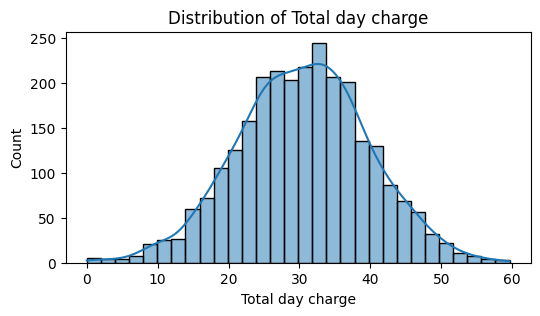

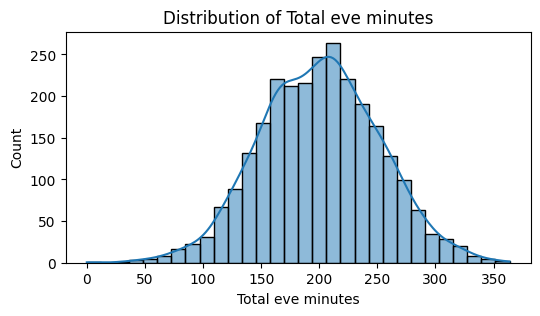

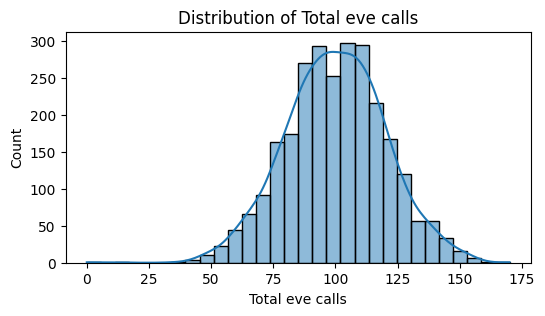

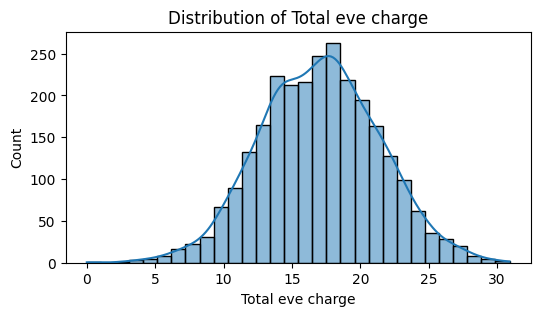

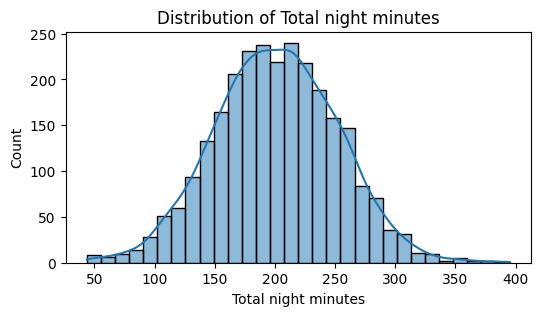

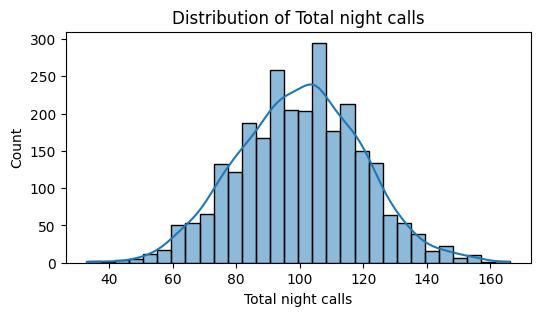

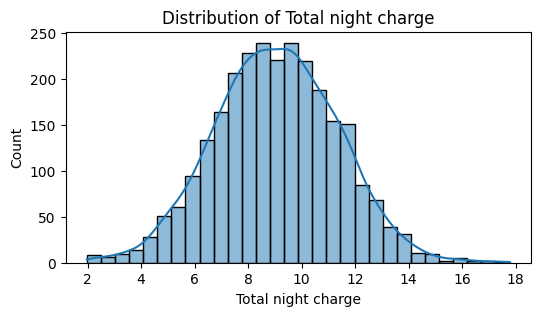

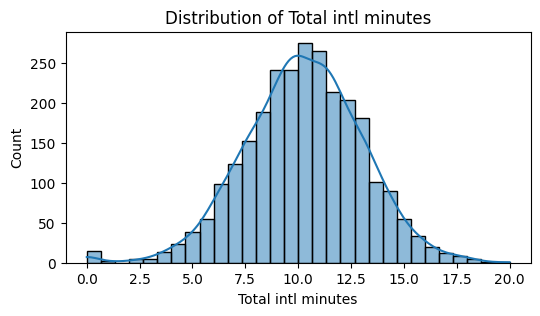

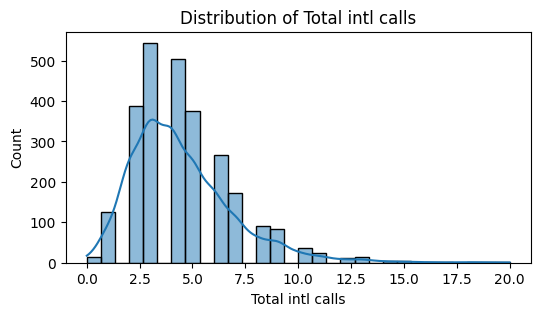

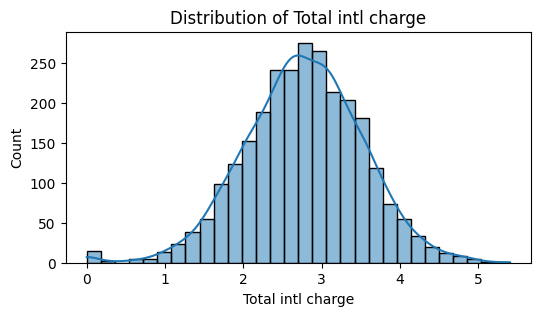

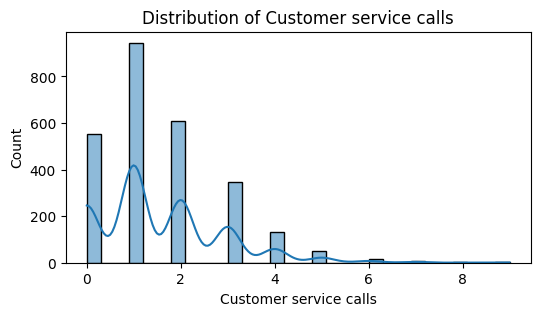

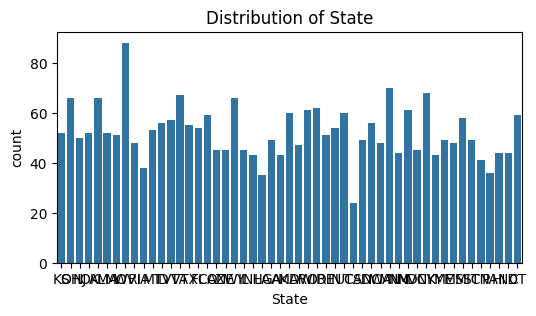

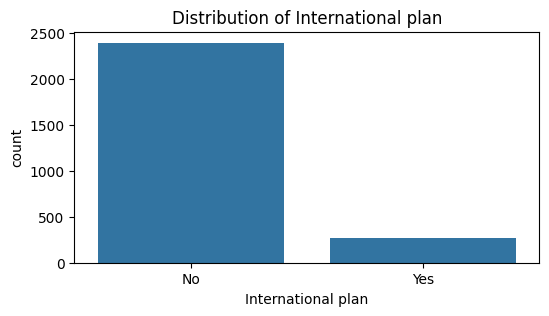

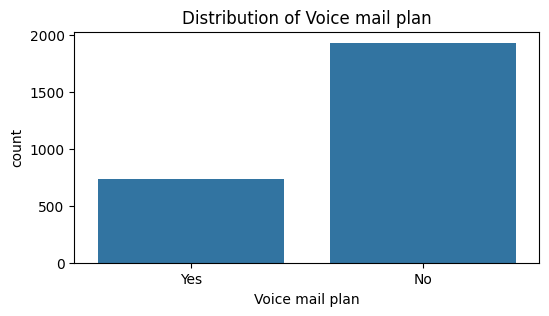

In [13]:
# === 5. בדיקה של עמודות קטגוריאליות ומספריות ===
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
# === 7. גרפים בסיסיים על פיצ'רים מספריים ===
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

# === 8. גרפים בסיסיים על פיצ'רים קטגוריאליים ===
for col in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.show()

**Test Data frame**

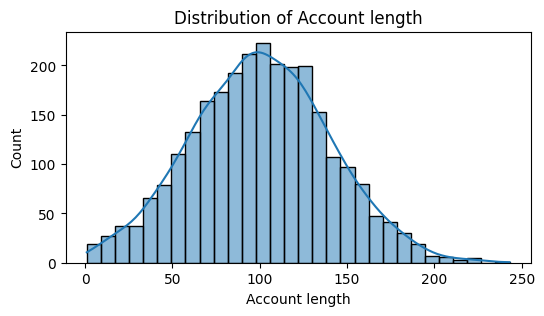

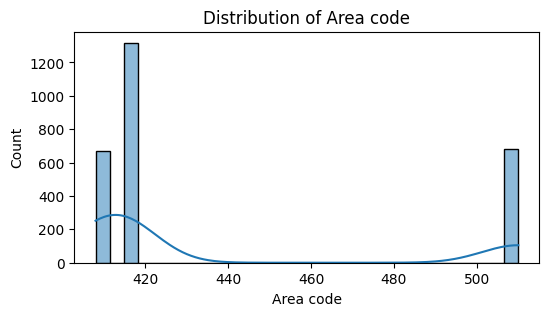

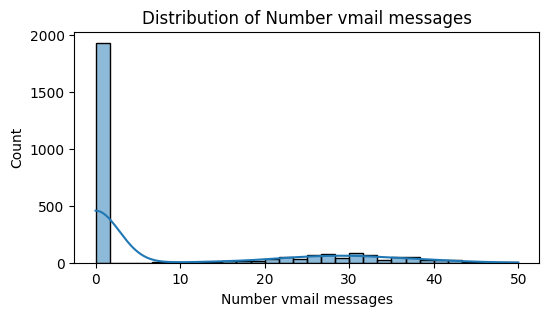

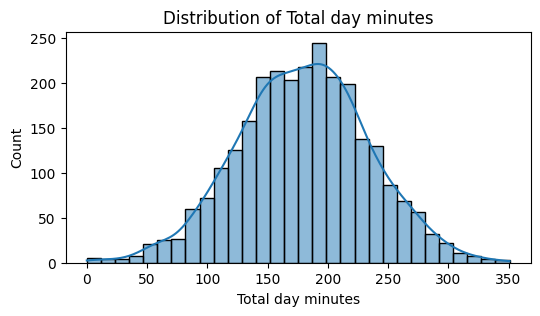

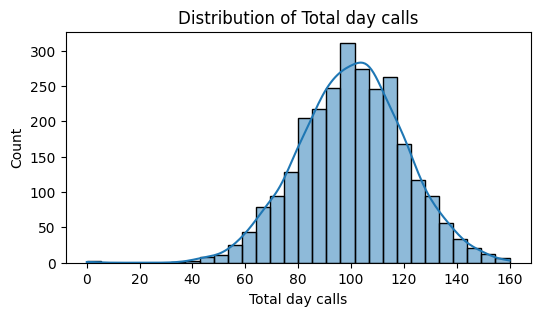

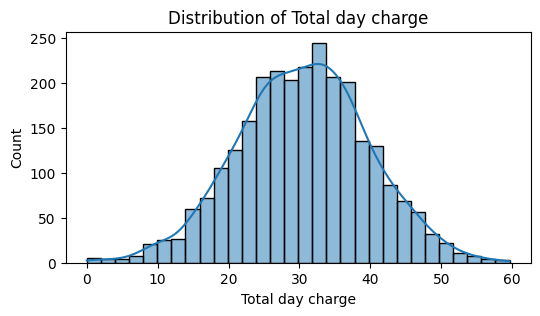

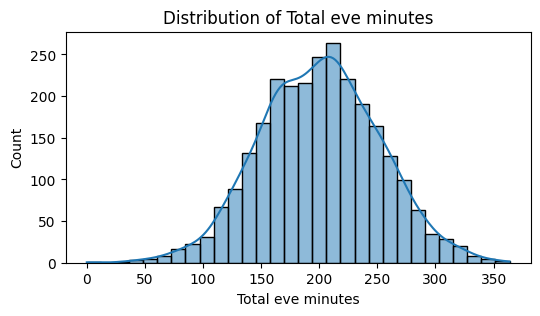

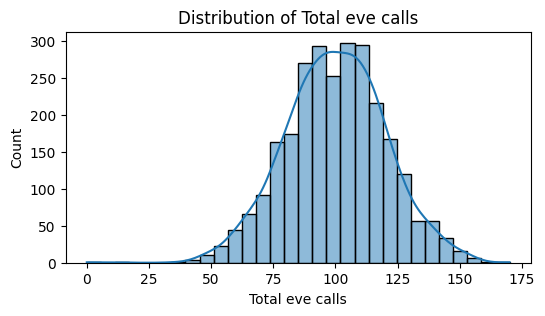

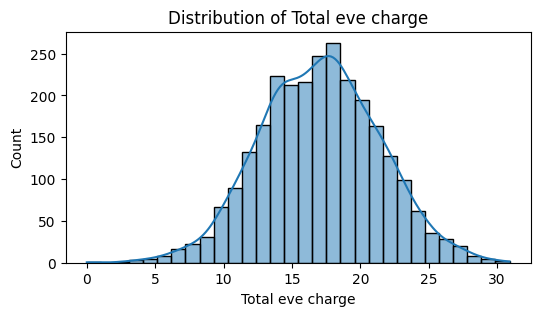

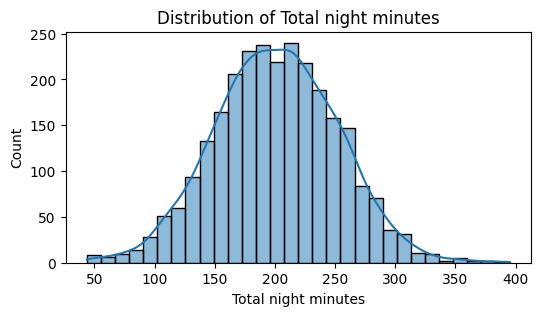

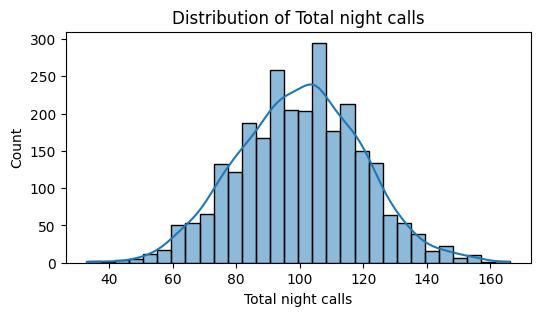

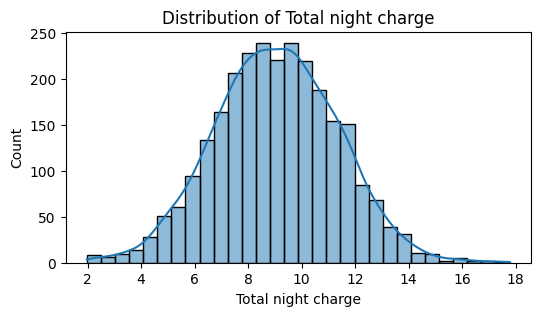

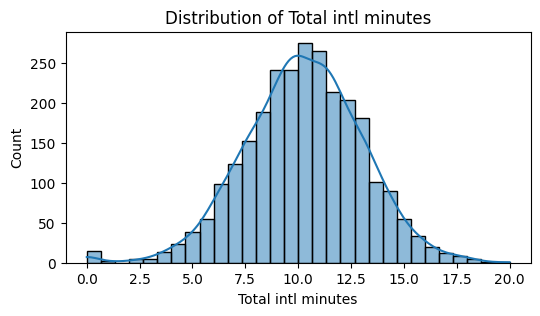

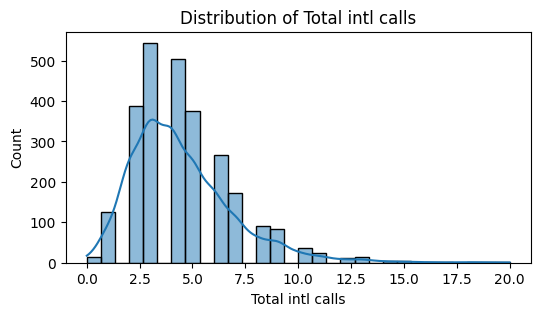

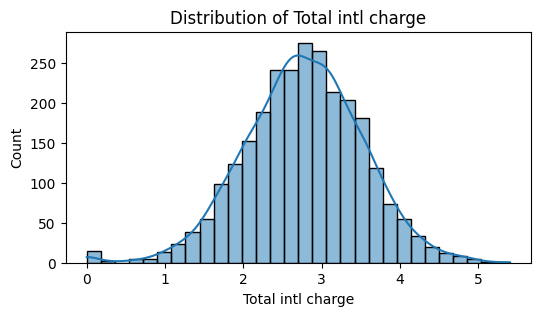

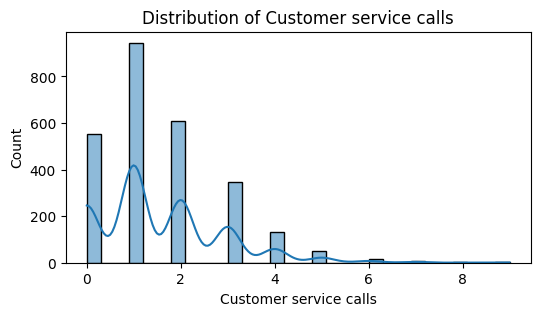

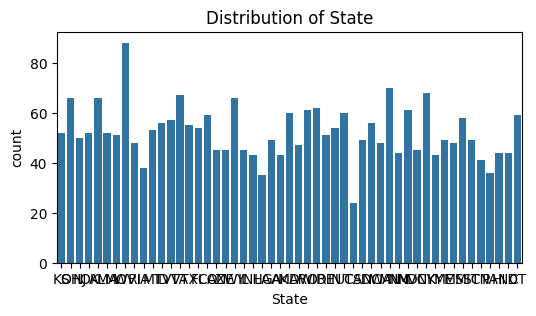

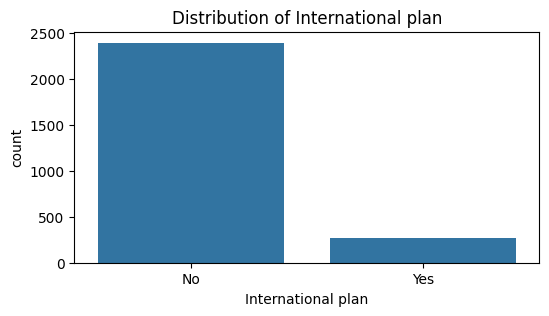

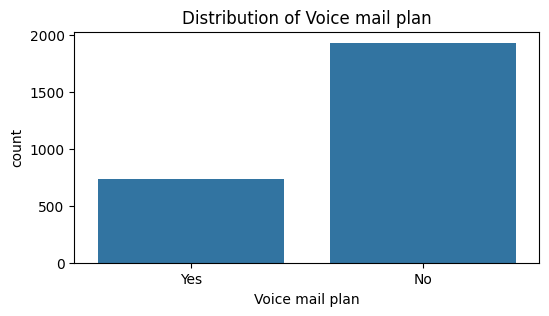

In [14]:
# === 5. בדיקה של עמודות קטגוריאליות ומספריות ===
cat_cols = df_test.select_dtypes(include=['object']).columns.tolist()
num_cols = df_test.select_dtypes(include=['int64', 'float64']).columns.tolist()
# === 7. גרפים בסיסיים על פיצ'רים מספריים ===
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

# === 8. גרפים בסיסיים על פיצ'רים קטגוריאליים ===
for col in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.show()

## Preproccesing

In [15]:
# === 3. target + features ===
target = "Churn"
X_train = df_train.drop(columns=[target])
y_train = df_train[target]

X_test = df_test.drop(columns=[target])
y_test = df_test[target]

# === 4. זיהוי קטגוריות ומספרים ===
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

# === 5. One-hot encoding לקטגוריות ===
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test  = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

Numeric: ['Account length', 'Area code', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']
Categorical: ['State', 'International plan', 'Voice mail plan']


## **Standart Scaler + One hot encoding**


In [16]:
# נוודא שהעמודות מתואמות בין train ל-test
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# === 6. נרמול על המספרים ===
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

## Train Model

In [ ]:

# === 7. XGBoost training ===
model = xgb.XGBClassifier(
    n_estimators=450,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])

)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=50
)

## Evaluation

In [18]:

# חיזוי הסתברויות
y_proba = model.predict_proba(X_test)[:, 1]

# נבחר threshold חדש
threshold = 0.4
y_pred_thresh = (y_proba >= threshold).astype(int)

print(f"--- תוצאות עם threshold = {threshold} ---")
print(classification_report(y_test, y_pred_thresh))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_thresh))


--- תוצאות עם threshold = 0.4 ---
              precision    recall  f1-score   support

       False       0.98      0.97      0.97       572
        True       0.83      0.85      0.84        95

    accuracy                           0.95       667
   macro avg       0.90      0.91      0.91       667
weighted avg       0.95      0.95      0.95       667

Confusion Matrix:
[[555  17]
 [ 14  81]]


## LogLoss Train vs Test

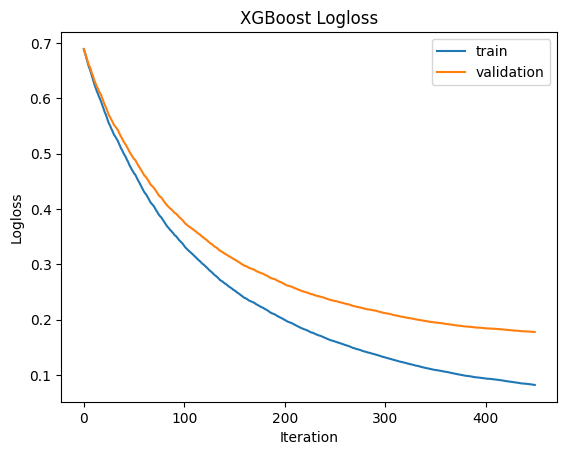

In [20]:
# --- גרף logloss ---
results = model.evals_result()
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='validation')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss')
plt.legend()
plt.show()